# Plotting of behavioral overviews

In [1]:
from oneibl.one import ONE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

one = ONE()


# Plotting variables
fs = 18 # fontsize

Connected to https://alyx.internationalbrainlab.org as sebastian


### Put in eid(s) of session(s), or find eid(s)

In [2]:
eids = ['4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b']

subjects = []
date_ranges = []
if len(eids) == 0:
    for s, d in zip(subjects, date_ranges):
        eids.append(one.search(subjects=s, date_range=d))
    # flatten list of lists
    eids = [item for sublist in eids for item in sublist]

### Defining functions for getting data and various plots

In [3]:
dataset_types = ['trials.choice', 'trials.contrastLeft', 'trials.contrastRight', \
                 'trials.feedbackType', 'trials.probabilityLeft', 'trials.response_times', \
                 'trials.stimOn_times', 'trials.goCue_times']


def get_df(eid):
    choices, contrastL, contrastR, feedback, probL, rt, stimOn, goCue = one.load(eid, dataset_types=dataset_types) # download_only=True messes with my code, returns path for whatever reason
    if np.all(None == choices) or np.all(None == contrastL) or np.all(None == contrastR) or np.all(None == feedback) or np.all(None == probL) or np.all(None == rt) or np.all(None == stimOn):
        return None, None
    d = {'response': choices, 'feedback': feedback}

    df = pd.DataFrame(data=d, index=range(len(choices)))

    if df.isnull().values.any():
        print("Warning, contains NaNs")
    if (df['feedback'] == 0).any():
        print("Warning, feedback contains 0's")
    # TODO: take care of this
    if (df['response'] == 0).any():
        print(df.index[df['response'] == 0])
        print("Warning, responses contains 0's (mouse didn't respond, special case)")

    # Avoid this, but then logic later needs to change
    df['feedback'] = df['feedback'].replace(-1, 0)
    df['response'] = df['response'].replace(-1, 0)
    df['signed_contrast'] = np.nan_to_num(contrastR) - np.nan_to_num(contrastL)
    df['contrast'] = np.abs(df['signed_contrast'])
    df['response'] = np.logical_not(df['response'])
    df['rt'] = rt - stimOn
    df['correct_answer'] = np.logical_not(df['response'] ^ df['feedback']) # calculation of what the actualy correct answer is, basically boolean of contrast (but doesnt work for 0)
    
    if (df['rt'] <= 0).any():
        print("Warning, bad RTs")

    return df, probL


def progression(data, contrasts, progression_variable='feedback', windowsize=6, upper_bound=None, legend=True, title=None):
    # looks somewhat irregular, red dots are not in middle of bump they cause, this is because distribution of specific contrasts is not uniform
    plt.figure(figsize=(14, 8))
    feedback = data[data['signed_contrast'].isin(contrasts)]['feedback']
    rights = data[(data['signed_contrast'].isin(contrasts)) & (data['feedback'] == 1)]['rt']
    wrongs = data[(data['signed_contrast'].isin(contrasts)) & (data['feedback'] == 0)]['rt']
    mean_value = np.mean(data[data['signed_contrast'].isin(contrasts)][progression_variable])
    progression = [np.mean(data[data['signed_contrast'].isin(contrasts)][progression_variable].values[i - windowsize : i + windowsize + 1]) for i in range(windowsize, len(feedback)-windowsize)]
    plt.gca().axhline(mean_value, c='k', label='mean ' + progression_variable)
    plt.plot(rights.index, rights, 'g.', label='correct')
    plt.plot(wrongs.index, wrongs, 'r.', label='wrong')
    plt.plot(feedback.index[windowsize:-windowsize], progression, 'b', label='average ' + progression_variable + ' over ' + str(2*windowsize+1) + ' trials')
    plt.ylim(0, upper_bound)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    if legend:
        plt.legend(fontsize=fs)
    if title:
        plt.title(title)
    plt.ylabel('RT', fontsize=fs)
    plt.xlabel('Trial', fontsize=fs)

    plt.show()

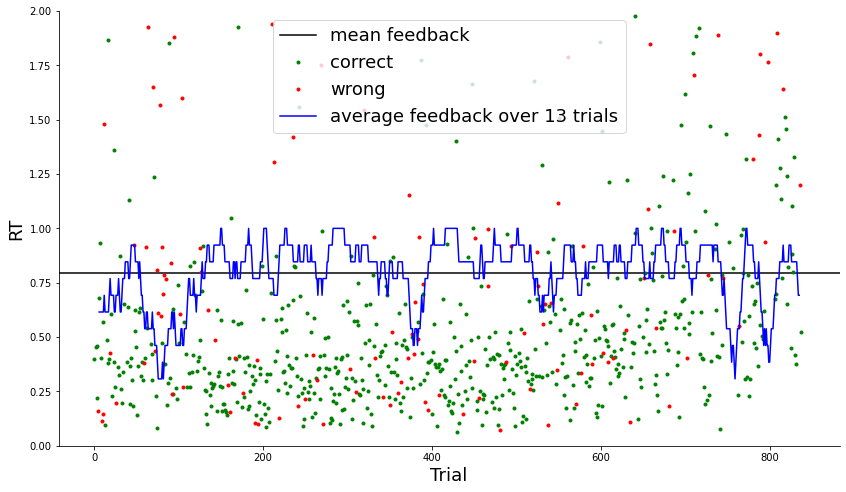

In [4]:
# Performance overview
for eid in eids:
    data, probL = get_df(eid)
    progression(data, data['signed_contrast'].unique(), progression_variable='feedback', upper_bound=2)

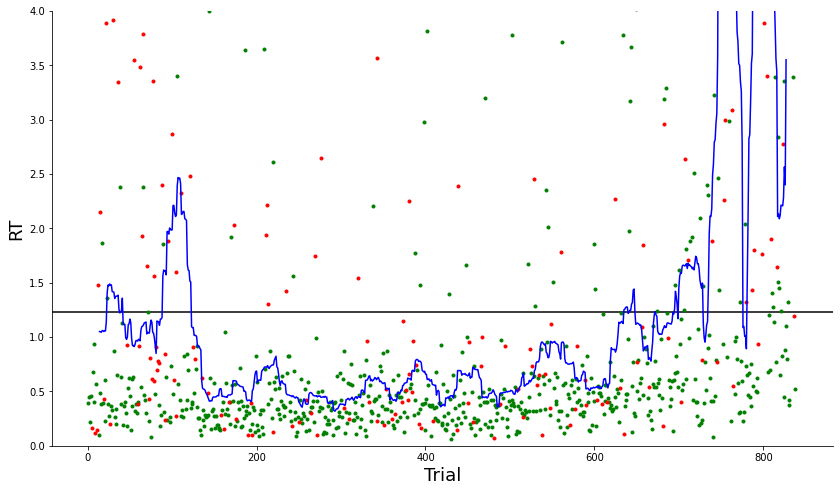

In [9]:
# RT overview
for eid in eids:
    data, probL = get_df(eid)
    progression(data, data['signed_contrast'].unique(), progression_variable='rt', windowsize=14, upper_bound=4, legend=False)

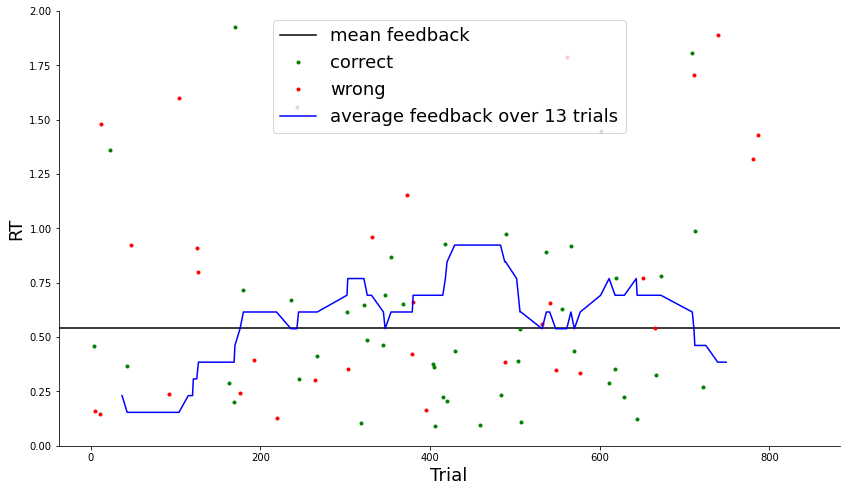

In [6]:
# Restrict plotted contrasts
for eid in eids:
    data, probL = get_df(eid)
    progression(data, [0.], progression_variable='feedback', upper_bound=2)

In [10]:
from ibl_pipeline.utils import psychofit as psy


ModuleNotFoundError: No module named 'ibl_pipeline'